In [1]:
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
import xarray as xr
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Tutorial 10: Working with netCDF data

[netCDF](https://www.unidata.ucar.edu/software/netcdf/) is a file format commonly used for storing spatially distributed time series such as climate data or ocean model output. **Section 7 of Tutorial 3** introduced the basic concepts of working with netCDF files in Python. This tutorial illustrates how to work with more complex files, in this case output from the biogeochemical model [ROMS](https://www.myroms.org/).

## 1. Read data from Thredds

netDCF files can be large - so large that storing them locally is often impractical. In this example, we will read data directly from met.no's [Thredds server](http://thredds.met.no/thredds/catalog/metusers/arildb/catalog.html), which will allow us to work with it effectively without having to download huge files.

The code below reads basic dataset properties (i.e. metadata), but not any data itself. xarray implements something called "lazy evaluation", which in this context means reading data and performing calculations is delayed until the last possible moment. This is usually a good thing when working with potentially large datasets, because it useful to be able to see what you're working with *before* you try readiing data into memory.

In [2]:
# Open dataset and print metadata summary
ncml_path = r'http://thredds.met.no/thredds/dodsC/metusers/arildb/MARTINI800_prov_v2.ncml' 
ds = xr.open_dataset(ncml_path)
ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 425, eta_rho: 426, eta_u: 426, eta_v: 425, ocean_time: 364, s_rho: 42, s_w: 43, tracer: 66, xi_psi: 479, xi_rho: 480, xi_u: 479, xi_v: 480)
Coordinates:
  * s_rho           (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w             (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2017-01-02 ... 2017-12-31
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes          int32 ...
    ndtfast 

In [6]:
type(ds['P1_Chl'])#.nbytes/1E9

xarray.core.dataarray.DataArray

Some things to note from the output above:

 * **Co-ordinates** define the structure of the nedCDF. **Dimension co-ordinates** (marked with an asterix in the output above, e.g. `* ocean_time`) are one dimensional arrays analogous to **indexes** in Pandas. **Non-dimension co-ordinates** are similar, but they can contain multi-dimensional data
 
   **Note:** In general, we might expect the output of a 3D (x, y, z) temporal model to  have four dimension co-ordinates: one for each spatial dimension, plus time. In this respect, ROMS output is a little strange, because two of the spatial dimensions (x, y) are not specified as "dimension co-ordinates". This is because the ROMS model works on an arbitrary Cartesian grid, so it is not possible to specify 1D index arrays of latitude and longitude co-ordinates. Instead, ROMS provides 2D grids of cell co-ordinates (`xi_rho` and `eta_rho`) together with corresponding grids of latitudes and longitudes (`lon_rho` and `lat_rho`). This makes slicing and indexing ROMS output a little awkward (see below), but saves the need for actually converting between co-ordinate systems
 
 * **Data variables**. The output for these shows which dimensions each variable is distributed over. For example, the variable `ntimes` is just a single number (a 32-bit integer) used across the entire model domain, whereas the variable `P1_Chl` is stored as a 32-bit floating point number varying by depth (`s_rho`), x-position (`xi_rho`), y-position (`eta_rho`) and time (`ocean_time`)
 
 * **Attributes**, which store additional metadata
 
## 3. Chunking

As mentioned above, netCDF files can be large. We can get the size of the dataset without having to read it into memory:

In [3]:
# Get size of dataset
print('The whole dataset is {:.2f} GB in size.'.format(ds.nbytes/1E9))

The whole dataset is 928.87 GB in size.


This dataset occupies almost a terrabyte, so we definitely don't want to try downloading the whole thing! In fact, it's so big that even downloading significant portions of it can be problematic: requests to the Thredds server will "time out" after a predefined interval, so if you request an operation that involves a substantial chunk of the data (such as calculating the mean along a single dimension), you might find that the Thredds connection "times out" before the data are transferred. If this happens you will see an error something like

    Runtime warning: No netCDF file
    
This is where **chunking** comes in.

xarray allows you to read netCDF data in "chunks" of a specified size. Data can therefore be downloaded in batches (i.e. multiple requests to Thredds) without time out issues and xarray will stitch everything together again afterwards. This does incur a performance penalty, so you should try to make the chunks as big as possible without causing server issues, but set against this are the benefits that (i) you can work with datasets too big to fit into memory, and (ii) you can actually get all the data you need from Thredds, even if it takes a while.

The code below re-read the original dataset, this time adding

    chunks={'s_rho':1,
            'eta_rho':200,
            'xi_rho':200}
            
This instructs xarray to consider each depth layer as a separate chunk, and to further sub-divide these horizontal slices into grids that are 200 cells square. From the initial metadata printed above, we know that most variables of interest are stored as 32-bit (= 4 byte) floats, each with 364 time steps. Based on this, we can estimate that - for a single variable - each chunk will be roughly $(1 \times 200 \times 200 \times 364 \times 4) = 58$ MB in size. This should be OK for a single request to Thredds.

In [4]:
# Read again using chunking
ds = xr.open_dataset(ncml_path,
                     chunks={'s_rho':1,
                             'eta_rho':200,
                             'xi_rho':200})

## 4. Choose variable(s) of interest

Further details for any specific variable can be found as illustrated below. We see that the variable `P1_Chl` corresponds to **chlorophyll a in mg/m<sup>3</sup>** and it is indexed over the three spatial dimensions, plus time. We can also see that there are: 42 depth "levels" in the `s_rho` direction; 426 cells in the `eta_rho` direction; 480 cells in the `xi_rho` direction; and 364 time steps.                    

In [5]:
# Get metadata (units etc.) for chl-a
chla = ds['P1_Chl']
chla

<xarray.DataArray 'P1_Chl' (ocean_time: 364, s_rho: 42, eta_rho: 426, xi_rho: 480)>
dask.array<shape=(364, 42, 426, 480), dtype=float32, chunksize=(364, 1, 200, 200)>
Coordinates:
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
    lon_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(200, 200)>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(200, 200)>
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-02 2017-01-03 ... 2017-12-31
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    diatoms/chlorophyll a
    units:        mg/m^3
    time:         ocean_time
    field:        P1_Chl, scalar, series
    _ChunkSizes:  [  1  14 142 160]

## 5. Explore chla-a

xarray provides a very flexible syntax for slicing and visualising datasets.

### 5.1. Map at specific date and depth

The `sel` method allows you to select data along any of the "dimension co-ordinates" i.e. those highlighted with an asterix in the metadata above. Note that in most netCDF files this would include indexing the spatial co-ordinates, but this is not the case for ROMS output (see the note in section 2, above).

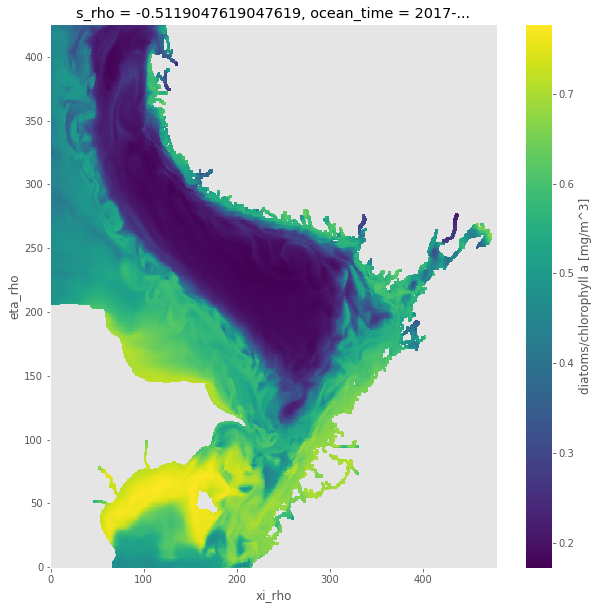

In [6]:
# Map chl-a on January 10th at depth = -0.5
chla.sel(ocean_time='2017-01-10', s_rho=-0.5, method='nearest').plot(figsize=(10,10))

### 5.2. Aggregate over dimensions

The syntax for aggregating data is straightforward, but **beware** - these operations often involve reading large portions of the original data, which can be slow! Think carefully about the order in which you do things: the code below first chooses a specific date of interest, and *then* averages over depth. You could do this the other way around and get the same result (i.e. average over all depths for each date, then pick the date of interest), but this would be roughly 364 times slower! 

The code here average chl-a over all depths for the last day in July.

In [7]:
# Average chl-a over all depths for 31.07.2017
chla_avg = chla.sel(ocean_time='2017-07-31').mean(dim='s_rho')
chla_avg

<xarray.DataArray 'P1_Chl' (eta_rho: 426, xi_rho: 480)>
dask.array<shape=(426, 480), dtype=float32, chunksize=(200, 200)>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(200, 200)>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<shape=(426, 480), chunksize=(200, 200)>
    ocean_time  datetime64[ns] 2017-07-31
Dimensions without coordinates: eta_rho, xi_rho

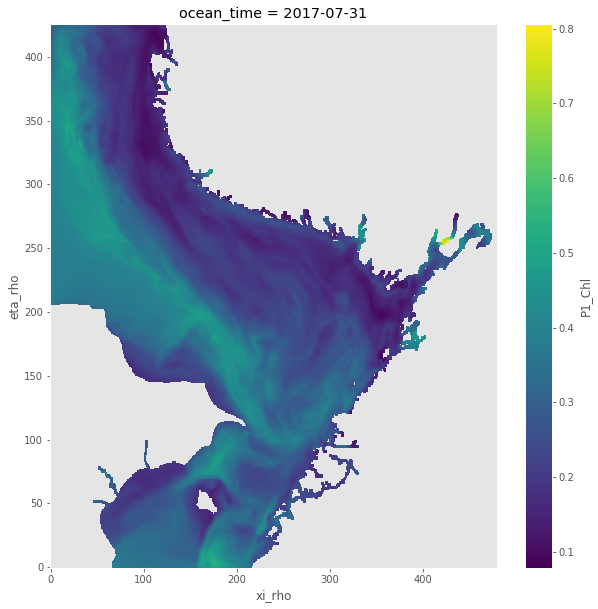

In [8]:
# Plot
chla_avg.plot(figsize=(10,10))

### 5.3. Extract time series for specified depth and location

As described in section 2, above, the ROMS output does not provide true indexes (i.e. dimension co-ordinates) over the x and y spatial dimensions. There are various workarounds for this. The code below is adapted from [Ann Kristin's notebooks](https://github.com/annks/Examples) and can be used to get the integer grid IDs for any pair of lat/lon co-ordinates.

In [9]:
def lonlat_to_xyindex(ds, lon, lat):
    """ ROMS uses a strange rotated projection. I can't find the proj.4 string
        in the metadata, but the lons and lats corresponding to each (x, y) are 
        stored. This function returns grid indices (xi, eta) for the specified 
        (lon, lat).  
        
        Refactored from Ann Kristin's "Examples" repository.
    
    Args:
        ds:  xarray dataset object. From ROMS model output
        lon: Float. Longitude
        lat: Float. Latitude
        
    Returns:
        Tuple of integers (xi_idx, etx_idx)
    """
    import numpy as np
    
    lons = ds['lon_rho'].values
    lats = ds['lat_rho'].values
    
    pos_diff = np.abs(lats - lat) + np.abs(lons - lon)
    i, j = np.unravel_index(pos_diff.argmin(), pos_diff.shape)
    
    return (j, i)

The code below uses the `lonlat_to_xyindex()` function to extract and plot a time series of **surface cla-a** for the station at Torbjørnskjær

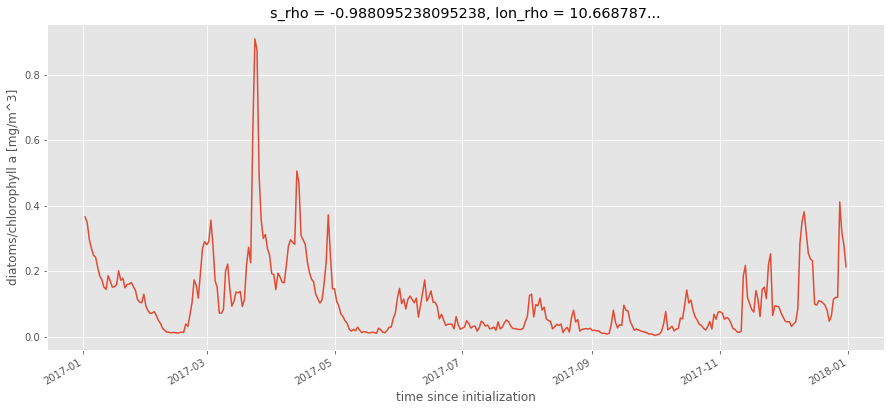

In [10]:
# Location of the Torbjørnskjær station
lon = 10.6653
lat = 59.0361
depth = 0     # Index value for surface

# Convert (lon, lat) to model (xi, eta)
x, y = lonlat_to_xyindex(ds, lon, lat)

# Extract time series
ts = chla.isel(xi_rho=x, eta_rho=y, s_rho=0)
ts.plot(figsize=(15,6))

### 5.4. Plot bathymetry

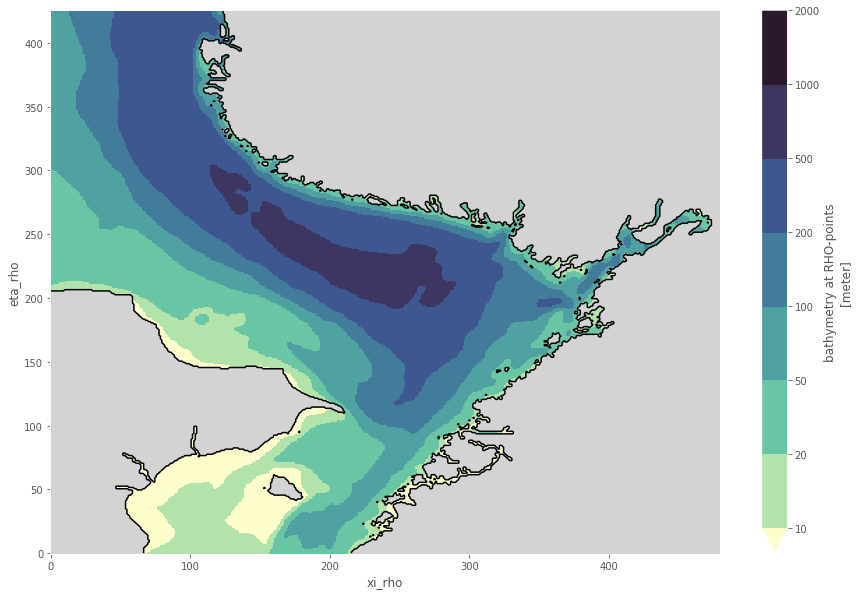

In [11]:
# Break-points for colour scheme (in m)
levels = [10, 20, 50, 100, 200, 500, 1000, 2000]

# Get depth data and plot
depths = ds['h'].where(ds.mask_rho > 0)   # Mask out land
depths.plot(levels=levels, cmap=cmo.deep, figsize=(15,10))

# Plot land as grey
land = ds.mask_rho
land.plot(levels=[1], colors='LightGrey', add_colorbar=False)

# Coast line
land.plot.contour(levels=[0.5], colors='black')

## 6. ROMS-specific functions

If you are specifically interested in working with ROMS model output, additional useful functions can be found in Bjørn Ådlandsvik's [xroms](https://github.com/bjornaa/xroms) package, which is installed in the DSToolkit. xroms is built around xarray and the syntax is similar to the examples above, but xroms includes some additional useful functions specifically designed for working with ROMS model output files. For further details, see the notebooks in the [xroms examples folder](https://github.com/bjornaa/xroms/tree/master/examples).